<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/6_Ensamble/bagging_boosting.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Ensambles: Bagging & Boosting

In [ ]:
#!pip install pydotplus 
!pip install scikit-plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Bagging:
Como mencionamos anteriormente, el problema inherente de los árboles de decisión es la alta varianza que poseen. Para comprender esto pensemos en el siguiente ejercicio: supongamos que ya hemos contruido un árbol de decisión sobre un dataset determinado. Ahora si dividimos dicho dataset en 2 partes y luego generamos un árbol de decisión para cada una de las partes, lo más probable es que obtengamos 2 nuevos árboles muy disímiles entre sí e incluso muy diferentes al árbol que generamos para el dataset original. 

También mencionamos que los métodos de ensamble ayudan a reducir el error por varianza aumentando asi el accuracy final del modelo. Veremos a continuación cómo funciona el método de Bagging:  
 
El nombre **Bagging** proviene de: **Bootsrap Aggregation**, veamos entonces primero qué significa Boostrap. 

> #### El método Bootstrap:
El método Bootstrap consiste en generar a partir de un dataset original, N nuevos datasets con la misma cantidad de variables independientes, y tomando muestras **con repetición**. Podemos observar que al aplicar la técnica de bootstrap, podemos tener observaciones repetidas dentro de los nuevos datasets.
>

![image](img/bootstrap_01.png)


Por lo tanto, el método de ensamble genera N modelos distintos al entrenar N árboles de decisión con N datasets "distintos". Estos datasets son creados a partir de la técnica de bootstrapping.  

![image](img/bagging_02.png)

Dependiendo de la naturaleza de la predicción, ya sea una clasificación o una regresión, vamos a tener que la predicción final del meta-modelos va a ser:  
- **Clasificación:** la predicción agregada se consigue mediante votación por mayoría. La clase que indique la mayoría de los modelos será la utilizada.
- **Regresión:** la predicción agregada utiliza el promedio de las regresiones de los modelos.

Al realizar Bagging no se realiza poda de los N árboles de decisión que luego se utilizan en el ensamble, ésto es para que los mismos tengan el menor error de bias posible aún cuando tengan un gran error de varianza. Luego, mediante la agregación, el méta-modelo reducirá el error de varianza de manera tal que:  

si la varianza de los modelos de árbol de decisión es $S^2$,  
entonces se espera que el modelo de bagging alcance un error de varianza de $\frac{S^2}{N}$


A través del próximo ejemplo de la librería scikit learn podemos demostrar la mejora que genera el método bagging por sobre un estimador único. Disminuyendo la varianza y el error. 

In [2]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

# Settings
n_repeat = 50       # iteraciones
n_train = 50        # tamaño del training set 
n_test = 1000       # tamaño test set 
noise = 0.1         # Desvío 
np.random.seed(0)

# Podemos probar distintos estimadores
# Funciona bien con estimador con mucha varianza como knn o descision trees,
# pero pobres para sistemas con poca varianza como regresiones lineales 

estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

#funciones para generar data 
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        #puntos y con ruido
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


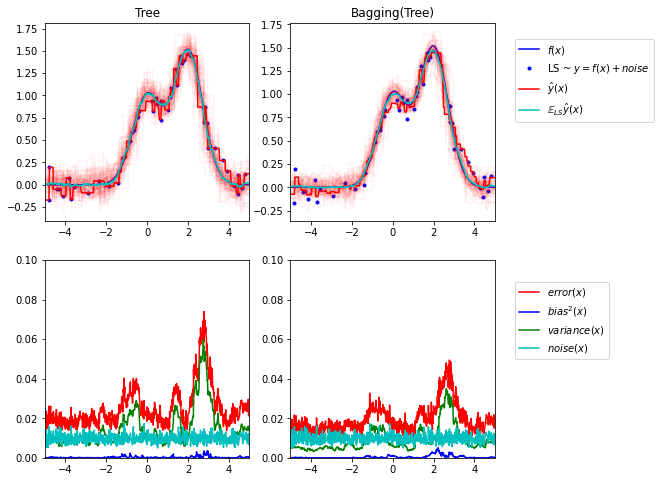

In [3]:
#preparamos las condiciones para los entrenamientos  
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# iteramos sobre los estimadores 
for n, (name, estimator) in enumerate(estimators):
    # precomputamos las predicciones 
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Obtenemos bias, varianza ruido y error 
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # ploteamos para cada estimador 
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

## Bagging implementación

Vamos a utilizar el dataset de diabetes que se encuentra precargado en la biblioteca sklearn.

El dataset consiste en 10 variables fisiológicas: edad, sexo, peso, presión sanguínea y otras medidas en 442 pacientes y la variable target es un indicador del progreso de la enfermedad.<br>
En sklearn todas las variables se encuentran estandarizadas, es decir, centradas a media cero y con norma l2. <br>
Para más información puede consultar el paper original <a href="http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf">aquí</a>

In [4]:
#Levantamos dataset
data = load_diabetes()
X = data['data']
y = data['target']

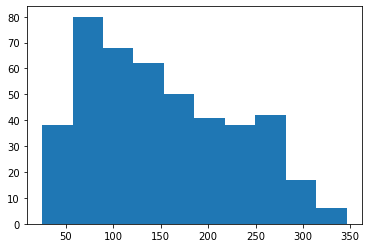

In [5]:
#Veamos la distribución de la clase
plt.hist(y);

In [6]:
# partimos en entrenamiento-prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

## Ensamble vs Modelo Base

A continuación generamos una función que devuelve el score de cross validation de cada estimador.

In [7]:
def do_cross_val(model):
    my_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=my_fold, n_jobs=-1, scoring='r2')
    return scores.mean(), scores.std()

Vamos a generar dos clasificadores para evaluar: dtr, que contiene el clasificador base y bdtr que contiene el ensamble y evaluamos la media y el desvío de ambos.

In [8]:
dtr = DecisionTreeRegressor(max_depth=2)
do_cross_val(dtr)

(0.3240456733873759, 0.1720752497620843)

In [9]:
bdtr = BaggingRegressor(dtr)
do_cross_val(bdtr)

(0.42290564600492386, 0.07906064176412952)

### Cambiando el número de estimadores

Ahora veamos qué pasa si vamos modificando la cantidad de estimadores que incluímos en el ensamble y la complejidad del modelo. La complejidad del modelo ser regula con el parámetro max_depth que indica la profundidad del árbol. 

In [10]:
# Definimos esta función para calcular ensambles de distinto tamaño sobre el estimador que recibe. 

def calcular_scoring_stddev_bagging(basereg):
    scores=[]
    stddevs=[]
    for numreg in range(1,50):
        bdtr = BaggingRegressor(basereg,n_estimators=numreg)
        score,stddev=do_cross_val(bdtr)
        scores.append(score)
        stddevs.append(stddev)
        print (". "),
    return np.array(scores),np.array(stddevs)

In [11]:
# Armamos los scores para un estimador de profundidad 1
scores_bagging_shallow,stddev_bagging_shallow=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=1))

#máximo score 
scores_bagging_shallow.max()

. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 


0.3690973532331153

In [12]:
# Con el parámetro max_depth = None, el árbol se expande hasta lograr una clasificación perfecta 
# sobre los datos de entrenamiento.
scores_bagging_deep,stddev_bagging_deep=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=None))
#máximo score
scores_bagging_deep.max()

. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 
. 


0.42717955423855825

## Comparación de modelos

Tenemos, entonces, los scores de ensambles construidos con una cantidad de estimadores que varía desde 1 a 50 para dos modelos de distinta complejidad. 

Vamos a graficar la media y el desvío de la performance de cada modelo medida en términos de "r2"

In [13]:
def graficar_curva(scores,stddev,color, label):
    x_axis=range(1,len(scores)+1)

    plt.plot(x_axis,scores,color, label = label)
    plt.plot(x_axis,stddev, color+"--", label = 'stddev_'+label)
    plt.fill_between(x_axis,scores + stddev, scores - stddev, alpha=0.1, facecolor=color)

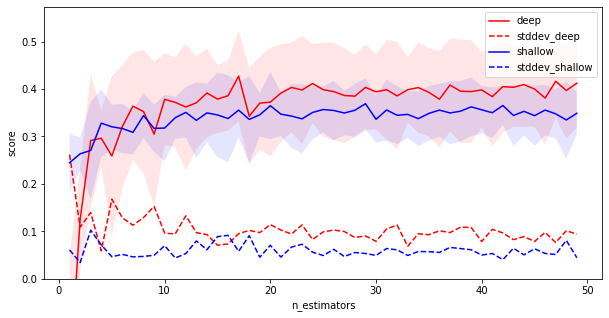

In [14]:
    
plt.figure().set_size_inches(10, 5)
graficar_curva(scores_bagging_deep,stddev_bagging_deep,"r",'deep')
graficar_curva(scores_bagging_shallow,stddev_bagging_shallow,"b", 'shallow')
plt.ylim(0)
plt.legend(loc='upper right')
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.show()

#### Interpretación del gráfico:

El modelo "simple" (azul) performa mejor que el rojo cuando hay un sólo modelo. Este modelo tiene mucho sesgo por ser extremadamente sencillo.

El modelo "complejo" (rojo) "aprende" perfectamente los datos de entrenamiento pero tiene problemas para generalizar en datos de validación. Por eso un único modelo tiene muy mala performance. Es un modelo con alta varianza.  

A medida que aumentamos la cantidad de modelos en el ensamble, el modelo rojo reduce la varianza de la predicción y alcanza resultados mejores que el modelo azul solamente con profundidad 1.


Para poder correr estas visualizaciones ejecutar:

pip install pydotplus 
conda install graphviz

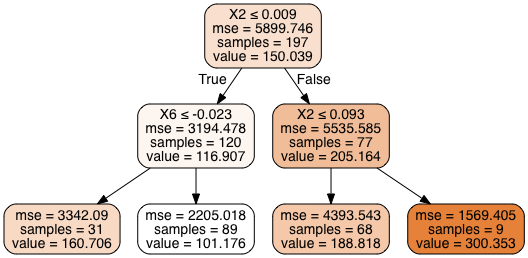

In [15]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=50)
bdtr.fit(X_train,y_train)


dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Ahora observemos el siguiente árbol del ensamble ¿Es similar? ¿Es muy diferente?

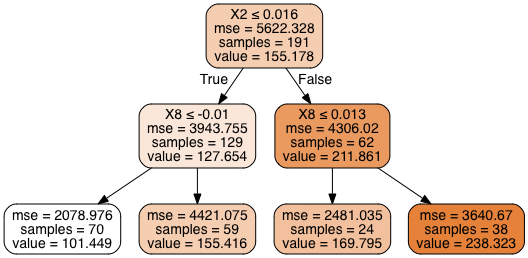

In [16]:
dot_data=export_graphviz(bdtr.estimators_[1], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Uno de los estimadores base, max_depth = 5

Observen cuánto crece la cantidad de parámetros estimada por el modelo cuando pasamos de una profundidad de 2 a una de 5.


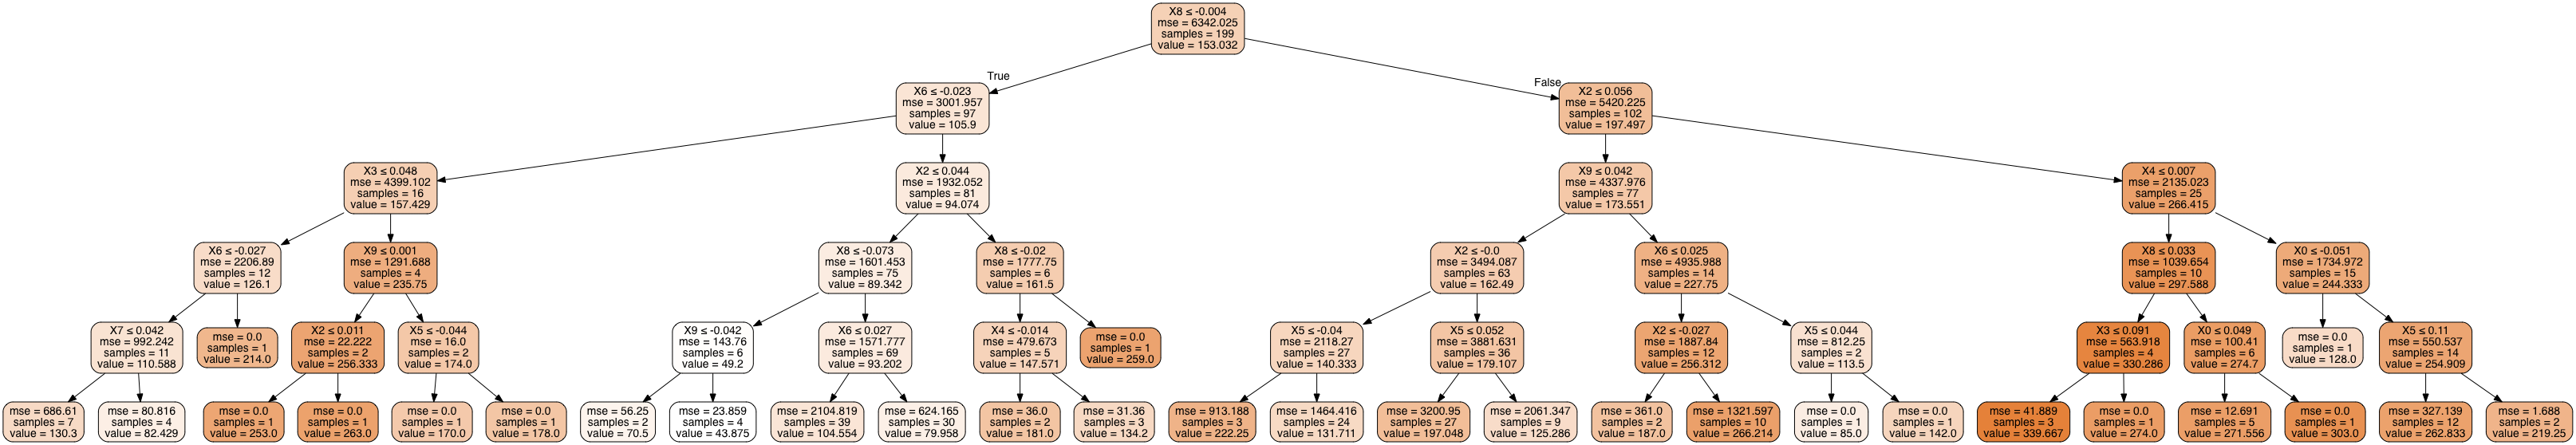

In [17]:
# Aqui mostramos uno de los estimadores que forman parte del ensamble
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=50)
bdtr.fit(X_train,y_train)


dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

dot_data=export_graphviz(bdtr.estimators_[1], out_file=None,  
                
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Conclusiones

---

* Los modelos de Ensamble generalmente presentan menos overfitting y mejor performance.

* Los métodos de Ensamble mejoran el rendimiento de los modelos base individuales gracias a su mayor capacidad para aproximar la función de predicción real en un problema de aprendizaje supervisado.

* Los métodos de Ensamble se desempeñan mejor en escenarios más complejos, pero pueden resultar en modelos muy complicados y difíciles de interpretar.



## 1. Algorítmos de bagging
Vamos a comparar el rendimiento de los siguientes algoritmos:

- Árboles de decisión
- Bagging sobre Árboles de decisión
- Random Forest
- Extra Trees

Para ello vamos a comenzar con la lectura del dataset de aceptabilidad de autos.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
names = ['buying','maint','doors','persons','lug_boot','safety','acceptability']
ds = pd.read_csv(url,names=names)
df.dtypes

buying           object
maint            object
doors            object
persons          object
lug_boot         object
safety           object
acceptability    object
dtype: object

Esta vez vamos a codificar los atributos usando un esquema One Hot, es decir, los consideraremos como variables categóricas. También vamos a codificar el target usando el `LabelEncoder`.

In [20]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
lab_enc.fit(df['acceptability'])

LabelEncoder()

In [21]:
y = lab_enc.transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))

X.iloc[:,0:8].head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh
0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1
3,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1


Hacemos el split entre train y test sets.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

Para que los resultados sean consistentes hay que exponer los modelos exactamente al mismo esquema de validación cruzada.

In [23]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=3, random_state=41, shuffle=True)

## 2. Comparando la performance de los árboles de decisión y ensambles de modelos
 
Ahora vamos a inicializar el clasificador de árbol de decisión, evaluar su rendimiento y compararlo con la perfomance de los ensambles que hemos visto hasta aquí. Para ello, vamos a usar los siguientes métodos:

### RandomForestClassifier()

Este método implementa y ejectua un RandomForest para resolver un problema de clasificación. Algunos de los parámetros más importantes son los siguientes:

* `n_estimators`: el número de iteraciones (o sea, de `base_estimators`) para entrenar
* `criterion`: define el criterio de impureza para evaluar la calidad de las particiones (por defecto, es `gini`) 
* `max_features`: la cantidad de features que extraerá para entrenar cada `base_estimator`. Por default es igual a `sqrt(X.shape[1])`
* `bootstrap` y `bootstrap_features`: controla si tanto los n_samples como las features son extraidos con reposición.
* `max_depth`: la pronfundidad máxima del árbol
* `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
* `min_samples_split`: el número mínimo de n_samples para realizar un split.

y varios otros que pueden llegar a ser importantes al momento de realizar el tunning. En general, los más importantes suelen ser: `n_estimators`, `max_features`, `max_depth` y `min_samples_leaf`.


### ExtraTreesClassifier()

Con este método se puede estimar un conjunto de conjuntos de árboles de decisión randomizados. Toma los mismos parámetros que `RandomForestClassifier()`.


### BaggingClassifier()

Este método es muy interesante porque, a diferencia de los anteriores, es un "meta estimador", está situado en nivel de abstracción mayor. Es decir, que permite implementar el algoritmo de bagging (para clasificación) con casi cualquier estimador de Scikit-Learn. Toma como parámetros análogos a los dos métodos anteriores (con diferentes valores por defecto en algunos casos). Los únicos "nuevos" son: 

* `base_estimator`: el estimador sobre el cual queremos correr el bagging (regresiones, árboles, etc...)
* `max_samples`: la cantidad de n_samples que muestrea en cada iteración. Por default es igual a `sqrt(X.shape[0])`


Para comparar los diferentes algoritmos armamos la siguiente función. Toma como input un estimador y un string con el nombre que le quieran poner, y ejecuta un `cross_val_score`

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier


def evaluar_rendimiento(modelo, nombre, X_train, y_train, cv):
    s = cross_val_score(modelo, X_train, y_train, cv=cv, n_jobs=-1)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))
    
    
dt = DecisionTreeClassifier(class_weight='balanced', random_state=1)

evaluar_rendimiento(dt,"Árbol de decisión", X_train, y_train, cv)

Rendimiento de Árbol de decisión:	0.957 ± 0.011


Ahora probamos con los modelos restantes y evaluamos el rendimiento.  
 * Bagging de Árboles de decisión
 * RandomForest
 * ExtraTrees

Documentación.   
http://scikit-learn.org/stable/modules/ensemble.html#forest

In [25]:
bdt = BaggingClassifier(dt, random_state=1)
rf = RandomForestClassifier(class_weight='balanced', random_state=1)
et = ExtraTreesClassifier(class_weight='balanced', random_state=1)

evaluar_rendimiento(dt,  "Árbol de decisión", X_train, y_train, cv)
evaluar_rendimiento(bdt, "Bagging AD", X_train, y_train, cv)
evaluar_rendimiento(rf,  "Random Forest", X_train, y_train, cv)
evaluar_rendimiento(et,  "Extra Trees", X_train, y_train, cv)

Rendimiento de Árbol de decisión:	0.957 ± 0.011
Rendimiento de Bagging AD:	0.945 ± 0.018
Rendimiento de Random Forest:	0.939 ± 0.012
Rendimiento de Extra Trees:	0.942 ± 0.014


En este caso, el bagging de árboles de decisión anda mejor que el resto.   
Con otros set de datos, los modelos Random Forest y Extra Trees podrían tener mejores resultados y merecen ser probados. Podríamos implementar un gridsearh para intentar realizar un tunning de los hiperparámetros...

## 3. Tuneando los hiperparámetros de RandomForest

In [26]:
from sklearn.model_selection import GridSearchCV
param_trees = {'n_estimators': [50, 100, 200], 
               'max_features': [1, 5, 8, 10, 21], 
               'max_depth': [5, 20, 50, 70, 100], 
               'min_samples_leaf':[1, 5, 8, 10, 50]}

In [27]:
grid_search_rf = GridSearchCV(rf, param_grid=param_trees, cv=cv, verbose=1, n_jobs=3)

In [28]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    9.2s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   38.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 1125 out of 1125 | elapsed:  3.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                      

In [29]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features=21,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Puede verse que realizando un proceso de tunnig es ahora RandomForest el algoritmo que mejora la perfomance de los clasificadores comparados.

In [44]:
evaluar_rendimiento(grid_search_rf,  "Random Forest GS", X_train, y_train, cv)

Rendimiento de Random Forest GS:	0.95 ± 0.009


<a id="section_introduccion"></a> 

## Boosting
### Introducción
Como mencionamos en la parte I, existen modelos de árboles de decisión simples, y árboles de decisión de Ensamble. Vimos también que los primeros, si bien son fáciles de interpretar, no pertenecen al grupo de modelos que ofrecen mayor precisión y que ésto se debía en gran medida a la varianza propia de dichos modelos. Como alternativa superadora surgieron los árboles de decisión por ensamble. Los modelos de Ensamble logran reducir la varianza inherente de los árboles de decisión y han logrados muy buenos resultados en cuanto a la precisión alcanzada, sin embargo ésto es a costa de perder la facilidad de interpretación que poseían los árboles de decisión simples.  
  

<a id="section_boosting"></a> 
### Boosting:
Boosting es la tercera técnica de agregación que veremos. La principal diferencia con las técnicas que vimos anteriormente, es que en ellas se entrenaban los modelos independientemente para luego generar un meta-modelo. En el caso de Boosting, se entrenan los modelos de manera secuencial donde cada modelo aprende de los errores del modelo predecesor. 

Las técnicas de boosting más conocidas son:
- ADA Boost
- Gradient Boosting

Veamos cada una de ellas:


**1) ADA Boost:**

El nombre ADA proviene de Adaptative Boosting, que hace referencia a su capacidad de Adaptar la importancia de los predictores asignándole mayor peso a aquellos sobre los que se comete más error. Es importante destacar que mientras en Random Forest mencionamos que a los árboles no se los poda, en el casode Adaboost sucede todo lo contrario: se suelen usar árboles de 1 nodo raíz y 2 nodos hojas. A este tipo de árboles se los conoce como **stump**. Por otro lado, mientras que en Random Forest cada árbol tenía igual voto sobre la predicción final, en el caso de ADA Boost tenemos que los votos de los **stumps** pueden tener más pesos unos que otros.  

Tal como mencionamos los métodos de boosting trabajan por definición secuencialmente, con lo cual cada **stump** va a "aprender" de la secuencia anterior. Al primer stump se lo va a entrenar con un dataset al cual se le va a asignar los mismos pesos a cada observación (fila). De esta manera si nuestro dataset tiene un total de K observaciones, entonces cada observación tendrá un peso de 1/K siendo todas igual de "importantes". 

Luego se elige el feature que genera la menor entropía o gini y se crea el primer stump con dicho feature. Calculamos ahora la importancia de dicho árbol (o cuanto peso tendrá su voto sobre la predicción del meta-modelo) dependiendo de la cantidad de error que cometió. Este error lo calculamos sumando los pesos de todas las observaciones que fueron mal clasificadas (este valor va a estar dentro del rango entre 0 y 1). 
- Si es 1 significa que no logró clasificar nada correctamente y por ende tendra muy poco voto en la predicción final.
- Si es 0 significa que clasifico todo perfectamente y por ende tendrá mayor voto en la predicción final.

A su vez, para asegurarnos que el siguiente stump pueda aprender del precursor, realizamos un ajuste de los pesos de cada observación del dataset. Ahora ya no serán todas las observaciones de igual peso o importancia, sino que se le dará mayor peso a aquellos observaciones que fueron mal clasificadas, y consecuentemente se le restará peso a aquellas que fueron correctamente clasificadas, de modo que siempre la suma total de pesos sea igual a 1.

Ahora el segundo Stump va a utilizar weighted Gini index para seleccionar la mejor partición, y a continuación se repiten todos los pasos:
- se calcula el error total de este stump para asignarle el peso a su voto.
- se vuelven a recalcular los pesos de cada observacion para entrenar al siguiente stump.


![image](img/Adaboost_01.png)

En este [link](https://www.youtube.com/watch?v=k4G2VCuOMMg) podemos ver el algoritmo en acción.

Este algoritmo es muy potente pero tiene desventajas como:

* Puede producir overfitting (el peso a los outliers va creciendo)
* No es interpretable
* No es multiclase (existen variantes como Adaboost.M1 que sí lo son)


La predicción del meta-modelo estará luego conformada de la siguiente manera:
- Clasificador: 
    - Voto con pesos
    - En sklearn: `AdaBoostClassifier`
- Regresión: 
    - Promedio ponderado
    - En sklearn: `AdaBoostRegressor`

**2) Gradient Boost:**

Gradient boosting es un método de aprendizaje lento donde los sucesivos modelos de árboles de decisión son entrenados para predecir los residuales del árbol antecesor permitiendo que los resultados de los modelos subsiguientes sean agregados y corrijan los errores promediando las predicciones. Para determinar los parámetros que tendrán cada uno de los árboles de decisión agregados al modelo se utiliza un procedimiento descenso por gradiente que minimizará la función de perdida. De esta forma se van agregando árboles con distintos parámetros de forma tal que la combinación de ellos minimiza la pérdida del modelo y mejora la predicción. 

La diferencia con adaboost es que ya no pesamos cada punto independientemente, sino que proponemos una función de error cuyo gradiente tenemos que minimizar. El hiperparámetro de Learning Rate ($\eta$) es un escalar entre 0 < $\eta$ < 1 que multiplica los residuales para asegurar convergencia. A medida que se reduce el valor de $\eta$ es recomendable aumentar el número de estimadores N.


La predicción del meta-modelo estará luego conformada de la siguiente manera:

$y_{pred} = y_1 + \eta r_1 + ... +  \eta r_N$


Árboles de decisión con Gradient boosting es uno de los modelos más poderosos y más utilizados para problemas de aprendizaje supervisado. Su principal inconveniente es que requieren un ajuste cuidadoso de los parámetros y puede requerir mucho tiempo de entrenamiento.

### scikit learn


### `AdaBoostClassifier()`

* `base_estimator`: análogo al caso de `BaggingClassifier()`, el estimador sobre el cual se va a construir el ensamble. Por efecto, son árboles de decisión.
* `n_estimators`: el máximo de iteraciones
* `learning_rate`: el peso que va a tener la predicción de cada árbol en el ensamble final


### `GradientBoostingClassifier()`

Se trata de una generalización del algoritmo general de Boosting para cualquier tipo de función de pérdida diferenciable. En cada etapa, se fitea un árbol de decisión pero se realiza sobre los residuos del árbol anterior. Es decir, se busca corregir las estimaciones entrenando nuevos clasificadores sobre los "residuos" (la diferencia entre el valor observado y el valor predico ($y - \hat{y}$)

Los argumentos que toma como input son ya conocidos:

* `learning_rate`: el peso que va a tener la predicción de cada árbol en el ensamble final

* `n_estimators`: el máximo de iteraciones
* `criterion`: define el criterio de impureza para evaluar la calidad de las particiones
* `max_features`: la cantidad de features que extraerá para entrenar cada `base_estimator`. Por default es igual a `sqrt(X.shape[1])`
* `bootstrap` y `bootstrap_features`: controla si tanto los n_samples como las features son extraidos con reposición.
* `max_depth`: la pronfundidad máxima del árbol
* `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
* `min_samples_split`: el número mínimo de n_samples para realizar un split.


In [45]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1), n_estimators=100)
gb = GradientBoostingClassifier()
evaluar_rendimiento(ab, "AdaBoostClassifier",  X_train, y_train, cv)
evaluar_rendimiento(gb, "GradientBoostingClassifier", X_train, y_train, cv)

Rendimiento de AdaBoostClassifier:	0.813 ± 0.037
Rendimiento de GradientBoostingClassifier:	0.966 ± 0.01


Puede verse, entonces, que AdaBoost performa bastante peor (al menos utilizando los parámetros por defecto). De esta forma, podríamos tratar de tunear los hiperparámetros para hacerlo funcionar mejor. 

In [46]:
params_ab = {"n_estimators": [100, 500],
          "learning_rate":[0.01, 0.1, 1.0],
        "base_estimator__max_depth": [1, 2, 3]}

grid_ab = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()), 
                       param_grid=params_ab, cv=cv, verbose=1, n_jobs=3)


In [47]:
grid_ab.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   17.0s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:   21.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                               

In [48]:
grid_ab.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [49]:
evaluar_rendimiento(grid_ab,  "AdaBoostClassifier + GS", X_train, y_train, cv)

Rendimiento de AdaBoostClassifier + GS:	0.921 ± 0.017


In [50]:
params_gb = {'n_estimators':[100, 500] , 
             'learning_rate':[0.001, 0.001, 0.1, 1.0],
            'max_depth' : [1, 2, 3, 4]}

grid_gb = GridSearchCV(gb, param_grid=params_gb, cv=cv, verbose=1, n_jobs=3)

In [51]:
grid_gb.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   37.7s
[Parallel(n_jobs=3)]: Done  96 out of  96 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=41, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  mi...
                                                  n_estimators=100,
                                    

In [52]:
grid_gb.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
evaluar_rendimiento(grid_gb, "GradientBoostingClassifier + GS", X_train, y_train, cv)

Rendimiento de GradientBoostingClassifier + GS:	0.972 ± 0.014


En este caso si vemos una mejora en la performance del Modelo de Gradient Boosting.  
Veamos a continuacion el valor de AUC y el gráfico de ROC

In [54]:
from sklearn.metrics import roc_auc_score
gb_auc = roc_auc_score(y_test,grid_gb.predict_proba(X_test),multi_class="ovr")
print("El valor del AUC es: ", gb_auc)

El valor del AUC es:  0.9997743685824576


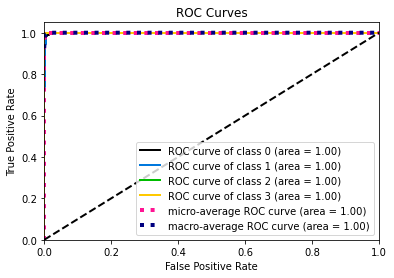

In [59]:
from scikitplot.metrics import plot_roc
plot_roc(y_test,grid_gb.predict_proba(X_test))

Finalmente vamos a graficar la importancia relativa de los feature para la predicción:

In [60]:
model = grid_gb.best_estimator_
model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [61]:
importances = model.feature_importances_
importances

array([8.05805532e-03, 5.81812354e-02, 5.06014143e-03, 3.79215617e-02,
       1.97421106e-03, 3.61294901e-02, 4.41883668e-02, 3.00984148e-02,
       5.58093745e-03, 6.61156391e-04, 8.96411473e-05, 8.03922112e-05,
       2.75980800e-01, 1.41185297e-03, 1.19658109e-02, 4.70136523e-03,
       8.75763557e-04, 1.49292447e-02, 6.63354496e-02, 3.73571478e-01,
       2.22046311e-02])

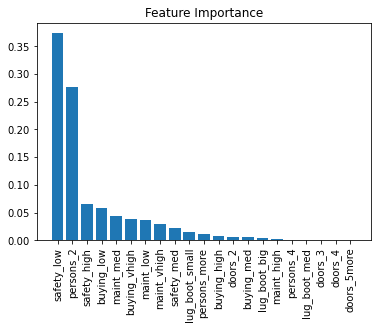

In [62]:
# Recordamos que argsort nos devuelve un vector con indices del vector original 
# tal que este quede reordenado de mayor a menor. 
# https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

# creamos una variable que tenga los indices indicando los valores de mayor a menor
indices = np.argsort(importances)[::-1]

# con dicha variable realizamos fancy indexing de manera de ordenar los labels del eje x.
names = X.columns[indices]

# Creamos el plot
plt.figure()

# Creamos plot title
plt.title("Feature Importance")

# Agregamos las barras
plt.bar(range(X.shape[1]), importances[indices])

# Agregamos los feature names 
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()